<a href="https://colab.research.google.com/github/filip-koselski/quantum-internship-task4/blob/main/Task4_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 57.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 27.1 MB/s 
     |████████████████████████████████| 16.7 MB 58.7 MB/s 
     |████████████████████████████████| 6.3 MB 55.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

from google.colab import files

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading Raster with rasterio

In [4]:
raster_path = "/content/drive/My Drive/SoilErosionDetection/T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

Checking Raster shape and Meta

In [5]:
print(raster_img.shape)

(3, 10980, 10980)


In [6]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

Using rasterio reshape to plot an image in matplotlib

In [7]:
raster_img = reshape_as_image(raster_img)

In [8]:
raster_img.shape

(10980, 10980, 3)

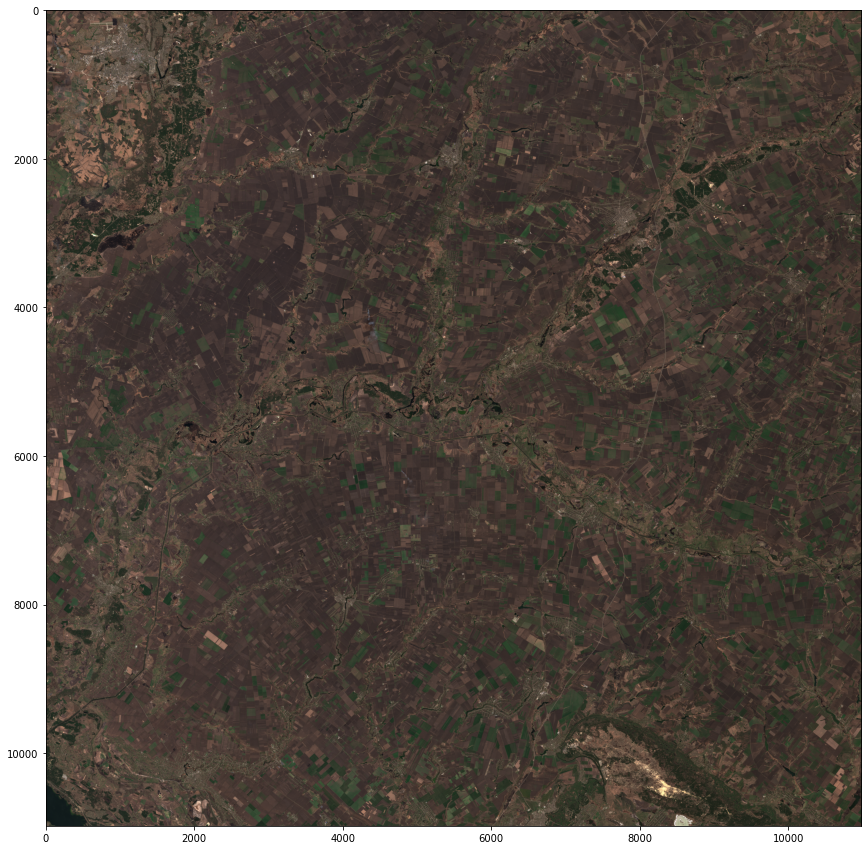

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

Reading train masks with GeoPandas

In [10]:
train_df = gpd.read_file("/content/drive/My Drive/SoilErosionDetection/Masks_T36UXV_20190427.shx")
print(len(train_df))
train_df.head(5)

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


In [11]:
train_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      object  
 1   Data        0 non-null      object  
 2   Code        340 non-null    float64 
 3   Descriptio  335 non-null    object  
 4   Comments    17 non-null     object  
 5   Image       325 non-null    object  
 6   geometry    935 non-null    geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 51.3+ KB


In [14]:
train_df.isna().sum()

id            936
Data          936
Code          596
Descriptio    601
Comments      919
Image         611
geometry        1
dtype: int64

There is one geometry feature NaN row - let's drop it

In [20]:
train_df = train_df[train_df.geometry.notna()]
train_df.isna().sum()

id            935
Data          935
Code          596
Descriptio    601
Comments      918
Image         611
geometry        0
dtype: int64

In [23]:
train_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 935 entries, 0 to 935
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      object  
 1   Data        0 non-null      object  
 2   Code        339 non-null    float64 
 3   Descriptio  334 non-null    object  
 4   Comments    17 non-null     object  
 5   Image       324 non-null    object  
 6   geometry    935 non-null    geometry
dtypes: float64(1), geometry(1), object(5)
memory usage: 58.4+ KB


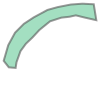

In [18]:
train_df['geometry'][100]

Checking Coordinate Reference System (CRS) of data

In [22]:
train_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

One may observe that data are in world geodetic system but input data is single Sentinel2 tile

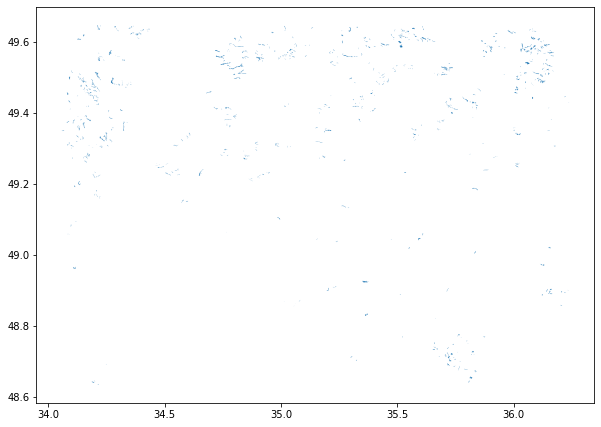

In [25]:
train_df.plot(figsize=(10,10)) #plotted polygons

In [26]:
train_df.Descriptio.value_counts()

color+ structure            211
branch of tree               73
color+ feathers              24
color (opodz)                11
small branch                  4
???                           3
color + feathers              2
branch + color+ feathers      2
brahch of tree                1
color+ feathers + branch      1
color (map NGO)               1
small tree                    1
Name: Descriptio, dtype: int64

Checking coordinates of polygon using Polygon methods

In [27]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

Trying to cut masks from Raster

In [28]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 935 files


Converting GeoDataframe to raster CRS using http://projfinder.com/ website - for an exemplary point from train_df the EPSG number is 4267

In [29]:
train_df = gpd.read_file("/content/drive/My Drive/SoilErosionDetection/Masks_T36UXV_20190427.shp")


# arange id numbers because they are all None
train_df["id"] = np.arange(len(train_df))

# assigning crs
train_df.crs = {'init' :'epsg:4267'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [30]:
train_df.head()

,id,Data,Code,Descriptio,Comments,Image,geometry
0,0,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((689961.152 5497804.667, 690037.456 5..."
1,1,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((691518.623 5497815.456, 691645.003 5..."
2,2,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((690017.383 5498399.293, 689968.112 5..."
3,3,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((689299.133 5498462.011, 689319.252 5..."
4,4,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((688152.716 5498615.331, 688249.512 5..."


Now coordinate reference system is correct

In [31]:
train_df.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Checking different types of soil erosion descriptions and codes

In [32]:
train_df.Code.value_counts()

1.0    239
2.0     74
5.0     13
3.0     10
9.0      3
4.0      1
Name: Code, dtype: int64

In [33]:
# train_df.groupby(["Code","Descriptio"]).size()
train_df.pivot_table(index=['Code', 'Descriptio'], 
               values=["id"], 
               aggfunc="size")

Code  Descriptio              
1.0   color + feathers              2
      color+ feathers              24
      color+ feathers + branch      1
      color+ structure            212
2.0   brahch of tree                1
      branch of tree               73
3.0   small branch                  4
      small tree                    1
4.0   color (map NGO)               1
5.0   branch + color+ feathers      2
      color (opodz)                11
9.0   ???                           3
dtype: int64

Cutting masks from Raster

In [34]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = 'drive/My Drive/SoilErosionDetection/cutted_fields'
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
#         print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 436 files


Preparing binary mask

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  import sys


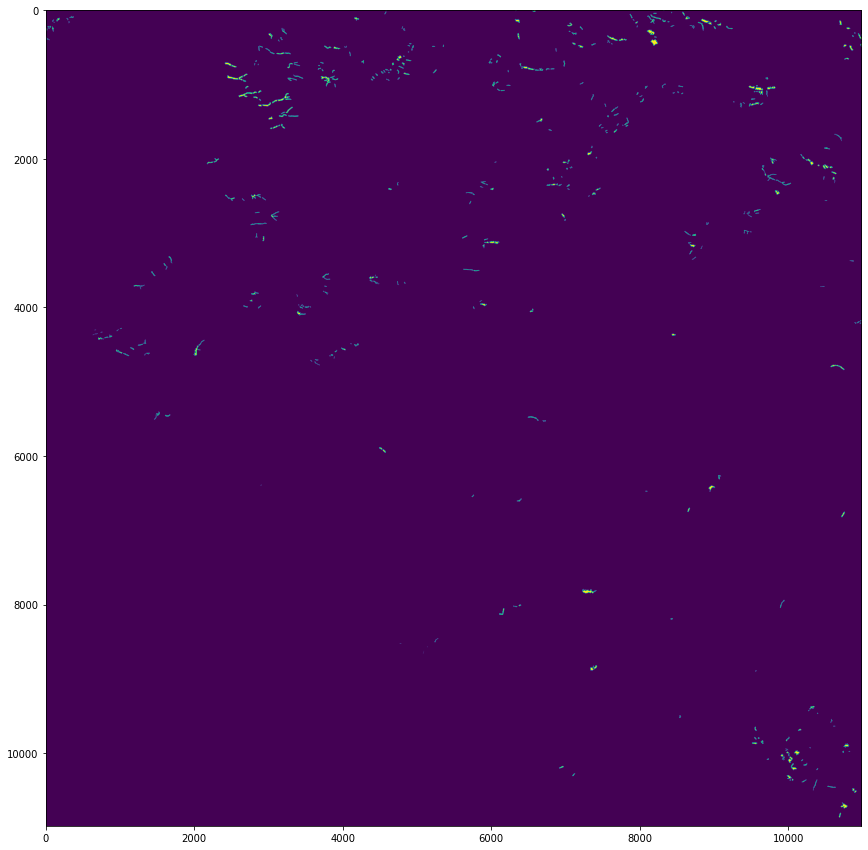

In [36]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# creating binary mask for erosion/not_erosion segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

Saving binary mask

In [37]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("/content/drive/MyDrive/SoilErosionDetection/train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

In [38]:
bin_mask_path = '/content/drive/MyDrive/SoilErosionDetection/train.jp2'
with rasterio.open(bin_mask_path, "r", driver="JP2OpenJPEG") as msk:
    bin_mask_img = msk.read()
    bin_mask_meta = msk.meta

In [39]:
print(bin_mask_img.shape)

(1, 10980, 10980)


In [40]:
bin_mask_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [41]:
bin_mask_raster_img = reshape_as_image(bin_mask_img)

In [42]:
bin_mask_raster_img[:,:,0].shape

(10980, 10980)

Plotting saved binary mask of whole tile with soil erosion polygons

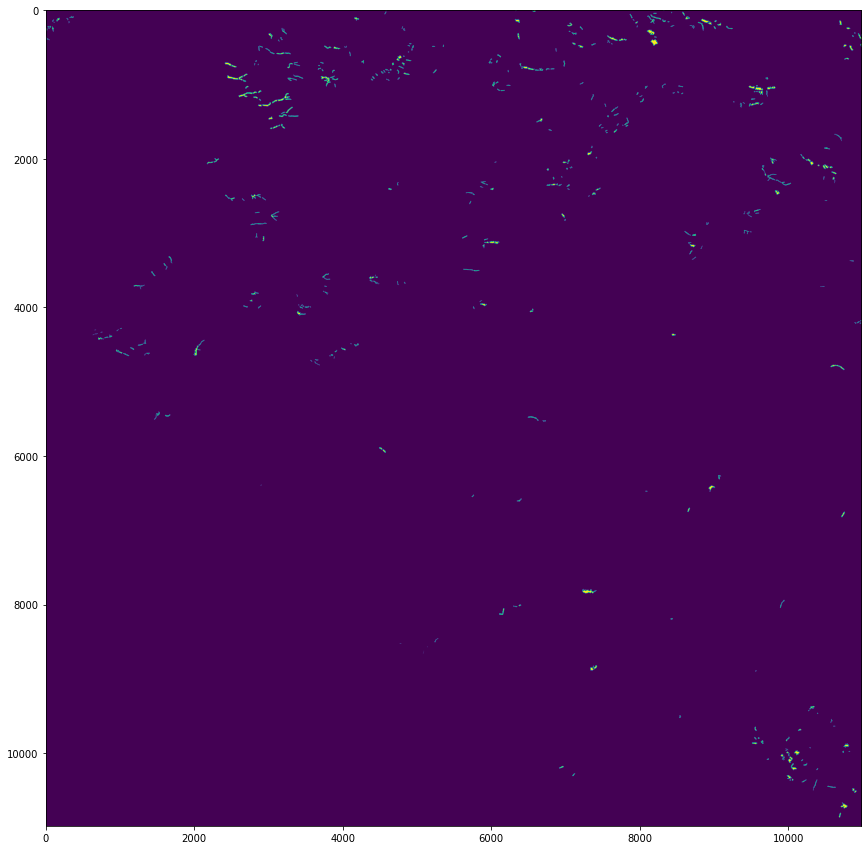

In [43]:
plt.figure(figsize=(15,15))
plt.imshow(bin_mask_raster_img[:,:,0])

# segmentation tiles was performed analogous to github https://github.com/Justdjent/remote_sensing_ucu/blob/main/notebooks/RS.%20Dataset%20preparation_completed.ipynb

In [44]:
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window

In [45]:
### splitting the image into segments:
def split_image(image_path, save_path, width, height):
    
    img_names = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    os.makedirs(f'{save_path}/images', exist_ok=True)
    with rasterio.open(image_path, "r") as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(
                    window=Window(i * width, j * height, width, height)
                )
                image_array = reshape_as_image(raster_window)[:, :, :3]
                if np.count_nonzero(image_array) > image_array.size * 0.9:
                    filename_w_ext = os.path.basename(image_path)
                    filename, _ = os.path.splitext(filename_w_ext)
                    image_format = 'png'
                    piece_name = f'{filename}_{j}_{i}.{image_format}'

                    image_array = reshape_as_image(raster_window)
                    img_name = f'{save_path}/images/{piece_name}'
                    img_names.append(img_name)
                    cv2.imwrite(img_name, image_array)

    return img_names

In [46]:
segmented_image_path = '/content/drive/MyDrive/SoilErosionDetection/segmented_data'
image_names = split_image(image_path=raster_path, save_path=segmented_image_path, width=256, height=256)

100%|██████████| 42/42 [00:45<00:00,  1.09s/it]


In [47]:
image_names[:3]

['/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_0.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_1.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_2.png']

In [48]:
#split mask
def split_mask(image_path, save_path, width, height):
    
    mask_names = []
    drop_list = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    my_image = None
    os.makedirs(f'{save_path}/masks', exist_ok=True)
    with rasterio.open(image_path) as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(window=Window(i * width, j * height, width, height))
                image_array = reshape_as_image(raster_window)
                filename_w_ext = os.path.basename(image_path)
                filename, _ = os.path.splitext(filename_w_ext)
                piece_name = f'{filename}_{j}_{i}.png'

                image_array = reshape_as_image(raster_window)
                image_array = image_array[:,:,0]
                    
                mask_name = f'{save_path}/masks/{piece_name}'
                mask_names.append(mask_name)
  
                if np.sum(image_array) == 0:
                    if np.random.random() < 0.9 :
                        drop_list.append(mask_name)
                image_array[image_array>1] = 1            
                cv2.imwrite(mask_name, image_array)

    return mask_names, drop_list, my_image

In [49]:
mask_path = '/content/drive/MyDrive/SoilErosionDetection/train.jp2'
segmented_mask_path = '/content/drive/MyDrive/SoilErosionDetection/segmented_data'
mask_names, drop_list, my_image = split_mask(image_path=mask_path, save_path=segmented_mask_path, width=256, height=256)

100%|██████████| 42/42 [00:12<00:00,  3.24it/s]


In [50]:
len(drop_list), len(mask_names)

(1363, 1764)

In [51]:
DROP_CSV_PATH = '/content/drive/MyDrive/SoilErosionDetection/segmented_data/drop_list.csv'
drop_list_df = pd.DataFrame()
drop_list_df['images_to_drop'] = drop_list
drop_list_df.to_csv(DROP_CSV_PATH, index=False)
drop_list[:5]

['/content/drive/MyDrive/SoilErosionDetection/segmented_data/masks/train_0_2.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/masks/train_0_3.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/masks/train_0_5.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/masks/train_0_6.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/masks/train_0_7.png']

In [52]:
image_names[:5]

['/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_0.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_1.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_2.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_3.png',
 '/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_0_4.png']

In [53]:
# create by removing masks 
used_image_names = [img_name for img_name in image_names if img_name.replace("images/T36UXV_20200406T083559_TCI_10m", 
                                                                             "masks/train") not in drop_list]
used_masks = [mask_names[i] for i in range(0, len(mask_names)) if mask_names[i] not in drop_list]

In [54]:
len(used_image_names),  len(used_masks)

(401, 401)

In [55]:
used_image_names[300]

'/content/drive/MyDrive/SoilErosionDetection/segmented_data/images/T36UXV_20200406T083559_TCI_10m_25_34.png'

In [56]:
used_masks[300]

'/content/drive/MyDrive/SoilErosionDetection/segmented_data/masks/train_25_34.png'

Exemplary segments img and mask

Text(0.5, 1.0, 'Mask num = 49')

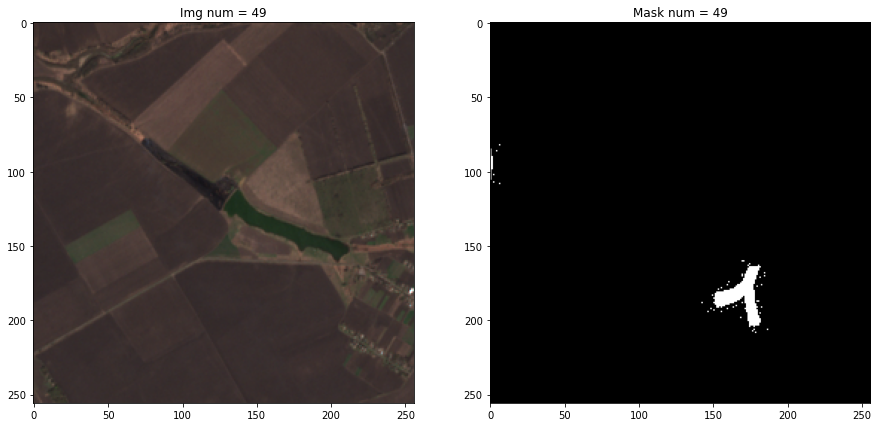

In [65]:
# read and plot tile
mask_num = np.random.choice(np.arange(0, len(used_masks)))

raster_imagee = cv2.imread(used_image_names[mask_num])
mask_imagee = cv2.imread(used_masks[mask_num], cv2.IMREAD_GRAYSCALE)


f, axarr = plt.subplots(1, 2)
f.set_size_inches((15,15))
axarr[0].imshow(raster_imagee)
axarr[1].imshow(mask_imagee, 'gray')
axarr[0].set_title(f'Img num = {mask_num}')
axarr[1].set_title(f'Mask num = {mask_num}')

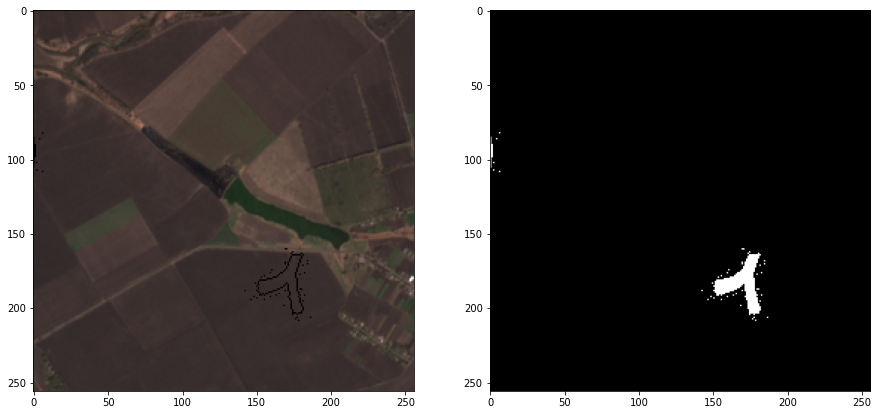

In [66]:
contours, hierarchy = cv2.findContours(mask_imagee, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(raster_imagee, contours, -1, (0,0,0), 1)

f, axarr = plt.subplots(1, 2)
f.set_size_inches((15,15))
axarr[0].imshow(raster_imagee)
axarr[1].imshow(mask_imagee, 'gray')

Text(0.5, 1.0, 'Mask num = 127')

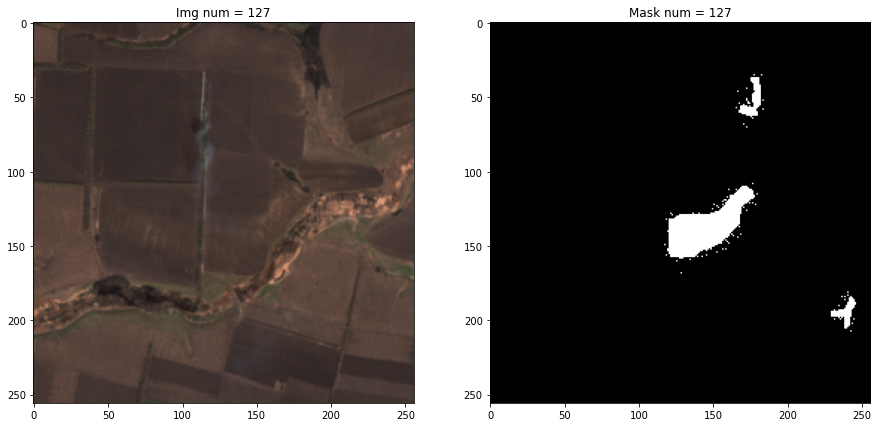

In [68]:
# read and plot tile
mask_num = np.random.choice(np.arange(0, len(used_masks)))

raster_imagee = cv2.imread(used_image_names[mask_num])
mask_imagee = cv2.imread(used_masks[mask_num], cv2.IMREAD_GRAYSCALE)


f, axarr = plt.subplots(1, 2)
f.set_size_inches((15,15))
axarr[0].imshow(raster_imagee)
axarr[1].imshow(mask_imagee, 'gray')
axarr[0].set_title(f'Img num = {mask_num}')
axarr[1].set_title(f'Mask num = {mask_num}')

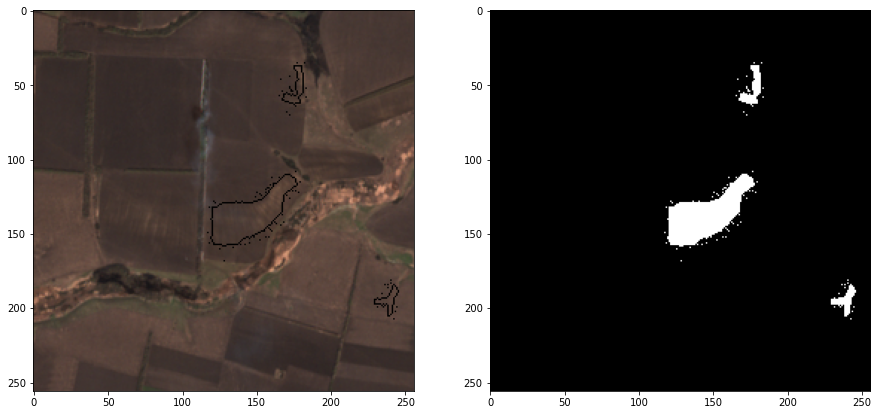

In [69]:
contours, hierarchy = cv2.findContours(mask_imagee, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(raster_imagee, contours, -1, (0,0,0), 1)

f, axarr = plt.subplots(1, 2)
f.set_size_inches((15,15))
axarr[0].imshow(raster_imagee)
axarr[1].imshow(mask_imagee, 'gray')